<a href="https://colab.research.google.com/github/martinfinis/HelloCodeSchoolProject/blob/master/RNN_Quest_1_Martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN_Quest_1: We will implement a pretrained RNN_Model and classify some artwork! After all, this is more fun than looking at welding seems or lung cancer data. 

You can download the data from: 

https://www.kaggle.com/ikarus777/best-artworks-of-all-time?select=artists.csv

Now only select the data in images of the following painters:

- Rembrandt
- Dürer
- Leonardo da Vinci
- Caravaggio 
- de Bongione 

These are required - if you want, you can also add others, like

- Michelangelo 

- Raffael

and even more. Just make sure that they are from sort of the same time and hence have a similar style. It's pretty easy to distinguish a Rembrandt from an Andy Warhol.

After you have done that, put the images into a data structure like in the Live-Coding last week. You can do that with the script from then (altered of course) - or just do it by hand. But please do not split into Train, Validation and Test set by hand. Use sklearn or any other method to randomly sample the images of each folder into the three sets. 




In [4]:
import keras,os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,BatchNormalization,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [63]:
import glob
import cv2
import keras,os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd

# Helper

In [6]:
import matplotlib.pyplot as plt

def history_plot_from_loss_acc(history, title):
  plt.figure(figsize=(10,5))

  train_loss_list = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss_list = history.history['val_loss']
  val_accuracy_list = history.history['val_accuracy']
  x = history.epoch
  
  plt.subplot(1,2,1)
  plt.plot(x, train_loss_list)
  plt.plot(x, val_loss_list)
  plt.legend(['train_loss', 'val_loss'])
  plt.title(title+"_ LOSS")
  
  plt.subplot(1,2,2)
  plt.plot(x, train_accuracy)
  plt.plot(x, val_accuracy_list)
  plt.legend(['train_acc','val_accuracy'])
  plt.title(title+"_ ACCURACY")
  plt.show()

In [7]:
# mount google drive to access dataset food
from google.colab import drive
drive.mount('/content/drive')
# change directory
%cd /content/
# create new local directory, i.e. on the current machine which you are connected to
!mkdir local_data   # could also be another name than local_data

Mounted at /content/drive
/content


In [8]:
#/content/drive/MyDrive/Copy_Material_AIDA_2021/Specialization_ML3/Week_3/resized.zip
!unzip '/content/drive/MyDrive/Copy_Material_AIDA_2021/_spec_ML3_wolfgang/Week_3/resized.zip' -d local_data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
 extracting: local_data/resized/Henri_Matisse_78.jpg  
  inflating: local_data/resized/Henri_Matisse_79.jpg  
  inflating: local_data/resized/Henri_Matisse_8.jpg  
  inflating: local_data/resized/Henri_Matisse_80.jpg  
  inflating: local_data/resized/Henri_Matisse_81.jpg  
  inflating: local_data/resized/Henri_Matisse_82.jpg  
  inflating: local_data/resized/Henri_Matisse_83.jpg  
  inflating: local_data/resized/Henri_Matisse_84.jpg  
  inflating: local_data/resized/Henri_Matisse_85.jpg  
  inflating: local_data/resized/Henri_Matisse_86.jpg  
  inflating: local_data/resized/Henri_Matisse_87.jpg  
  inflating: local_data/resized/Henri_Matisse_88.jpg  
 extracting: local_data/resized/Henri_Matisse_89.jpg  
  inflating: local_data/resized/Henri_Matisse_9.jpg  
  inflating: local_data/resized/Henri_Matisse_90.jpg  
  inflating: local_data/resized/Henri_Matisse_91.jpg  
  inflating: local_data/resized/Henri_Matisse_92.jpg  


In [10]:
cd /content/

/content


In [ ]:
#!mkdir training_set
#!mkdir test_set

In [ ]:
#ls -l

In [ ]:
#rm -r ./local_data/

In [11]:
#/content/local_data/resized
#data_path = 'C:/_dev/_aida/scientificProject/data/w_3/resized'
data_path = '/content/local_data/resized'

#/content/local_data/
#main_target_path = 'C:\\_dev\\_aida\\scientificProject\\data\\w_3\\'
main_target_path = '/content/local_data'


all_subdir = 'data_set'
train_subdir = 'train'
val_subdir = 'valid'
test_subdir = 'test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

artist_list = ['Caravaggio','Giotto_di_Bondone','Leonardo_da_Vinci','Rembrandt','Albrecht_Duerer']
data_format = '/*.jpg'


# import and organize images

In [12]:
#artist_list = ['Caravaggio','Giotto_di_Bondone','Leonardo_da_Vinci','Rembrandt','Albrecht_Duerer']

for file_name in listdir(data_path):
    print(file_name)

    #convert Albrecht_DuÔòá├¬rer
    if file_name.startswith('Albrecht_DuтХа├кrer'):
        new_file_name = file_name.replace('Albrecht_DuтХа├кrer','Albrecht_Duerer_x')
    elif file_name.startswith('Albrecht_Du╠Иrer'):
        new_file_name = file_name.replace('Albrecht_Du╠Иrer','Albrecht_Duerer_y')
    else:
        new_file_name = file_name

    for artist_name in artist_list:
        if new_file_name.startswith(artist_name):
            filepath = os.path.join(data_path,file_name)
            new_filepath = os.path.join(main_target_path,all_subdir,artist_name,new_file_name)

            #check dir and create
            if not os.path.exists(os.path.join(main_target_path,all_subdir,artist_name)):
                os.makedirs(os.path.join(main_target_path,all_subdir,artist_name))
            #move file
            try:
                os.rename(filepath, new_filepath)
            except:
                continue

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Paul_Gauguin_232.jpg
Salvador_Dali_63.jpg
Rembrandt_214.jpg
Albrecht_DuтХа├кrer_221.jpg
Peter_Paul_Rubens_92.jpg
Rembrandt_18.jpg
Pierre-Auguste_Renoir_46.jpg
Edgar_Degas_483.jpg
Hieronymus_Bosch_89.jpg
Rembrandt_235.jpg
Paul_Cezanne_1.jpg
Francisco_Goya_276.jpg
Albrecht_Du╠Иrer_172.jpg
Peter_Paul_Rubens_132.jpg
Albrecht_DuтХа├кrer_132.jpg
Francisco_Goya_75.jpg
Albrecht_DuтХа├кrer_249.jpg
Vincent_van_Gogh_619.jpg
Jan_van_Eyck_28.jpg
Henri_Matisse_101.jpg
Marc_Chagall_5.jpg
Albrecht_DuтХа├кrer_295.jpg
Marc_Chagall_184.jpg
Frida_Kahlo_49.jpg
Rembrandt_96.jpg
Vincent_van_Gogh_562.jpg
Vincent_van_Gogh_511.jpg
Edgar_Degas_246.jpg
Albrecht_Du╠Иrer_100.jpg
Edgar_Degas_566.jpg
Amedeo_Modigliani_56.jpg
Salvador_Dali_57.jpg
Albrecht_DuтХа├кrer_93.jpg
Francisco_Goya_18.jpg
Frida_Kahlo_87.jpg
Camille_Pissarro_46.jpg
Edgar_Degas_470.jpg
Alfred_Sisley_24.jpg
Titian_243.jpg
Albrecht_DuтХа├кrer_18.jpg
Pierre-Auguste_Renoir_172.jpg
Pabl

In [13]:
import glob
data_format = '/*.jpg'

def number_of_images_in_path(target_path,data_format):
    print(target_path)
    img_path_list = glob.glob(target_path + data_format)
           
    n = len(img_path_list)
    print(f'Number of images: {n}\n')

for artist_name in artist_list:
    number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,artist_name),data_format)

/content/local_data/data_set/Caravaggio
Number of images: 55

/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

/content/local_data/data_set/Rembrandt
Number of images: 262

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656



Now explore the data. 

- What are the different image dimensions?

- How are the labels distributed?

- What else would be useful to know?

In [14]:
def get_image_information(main_target_path,sub_path ,class_list ,data_format ):
    info_array = []#np.array([[0,8]])
    column_names = ['class','name','row','column','channel','shape','main_target_path','sub_path']

    for class_name in class_list:
        path = os.path.join(os.sep,main_target_path,sub_path,class_name)
        img_path_list = glob.glob(path + data_format)

        for img_path in img_path_list:
            img = cv2.imread(img_path)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            info_array.append([class_name,os.path.split(img_path)[-1],img.shape[0],img.shape[1],img.shape[2],img.shape,main_target_path,sub_path])

    df = pd.DataFrame(data=info_array,columns= column_names)
    return df

df =get_image_information(main_target_path=main_target_path,sub_path=all_subdir,class_list=artist_list,data_format=data_format)
df

,class,name,row,column,channel,shape,main_target_path,sub_path
0,Caravaggio,Caravaggio_24.jpg,527,750,3,"(527, 750, 3)",/content/local_data,data_set
1,Caravaggio,Caravaggio_42.jpg,1597,1214,3,"(1597, 1214, 3)",/content/local_data,data_set
2,Caravaggio,Caravaggio_1.jpg,600,415,3,"(600, 415, 3)",/content/local_data,data_set
3,Caravaggio,Caravaggio_23.jpg,800,614,3,"(800, 614, 3)",/content/local_data,data_set
4,Caravaggio,Caravaggio_17.jpg,767,946,3,"(767, 946, 3)",/content/local_data,data_set
...,...,...,...,...,...,...,...,...
1230,Albrecht_Duerer,Albrecht_Duerer_y_103.jpg,614,479,3,"(614, 479, 3)",/content/local_data,data_set
1231,Albrecht_Duerer,Albrecht_Duerer_x_17.jpg,614,490,3,"(614, 490, 3)",/content/local_data,data_set
1232,Albrecht_Duerer,Albrecht_Duerer_y_17.jpg,614,490,3,"(614, 490, 3)",/content/local_data,data_set
1233,Albrecht_Duerer,Albrecht_Duerer_x_189.jpg,1229,803,3,"(1229, 803, 3)",/content/local_data,data_set


In [15]:
df['size'] = df.apply(lambda x: x.row*x.column,axis=1)

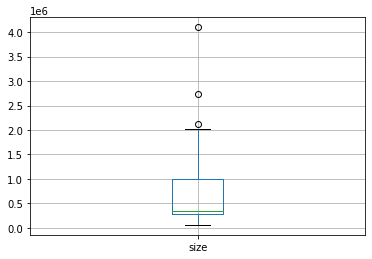

In [16]:
df[['size']].boxplot()

In [17]:
df['size'].quantile([0.25,0.5,0.75,1])

0.25     278142.0
0.50     345575.0
0.75     989959.5
1.00    4100656.0
Name: size, dtype: float64

In [18]:
df['size'].describe()

count    1.235000e+03
mean     5.997369e+05
std      4.604973e+05
min      6.030000e+04
25%      2.781420e+05
50%      3.455750e+05
75%      9.899595e+05
max      4.100656e+06
Name: size, dtype: float64

In [19]:
df_group = df.groupby('class').agg(img_count=('class','count'),size_mean=('size','mean'),size_min=('size','min'),size_max=('size','max')).reset_index()

In [20]:
import math
df_group['size_mean_sqrt'] = df_group['size_mean'].apply(lambda x: math.sqrt(x))

In [21]:
df_group

,class,img_count,size_mean,size_min,size_max,size_mean_sqrt
0,Albrecht_Duerer,656,736346.371951,93240,1866851,858.106271
1,Caravaggio,55,872363.345455,158760,2028594,934.003932
2,Giotto_di_Bondone,119,312735.689076,157700,373240,559.227761
3,Leonardo_da_Vinci,143,365021.181818,60300,1574195,604.169829
4,Rembrandt,262,458924.843511,97560,4100656,677.439919


In [22]:
df.groupby('class').agg(row_min=('row','min'),row_max=('row','max'),row_maen=('row','mean'),column_min=('column','min'),column_man=('column','max'),column_mean=('column','mean'))

,row_min,row_max,row_maen,column_min,column_man,column_mean
class,,,,,,
Albrecht_Duerer,239,1229,899.481707,241,1536,736.542683
Caravaggio,417,1671,922.890909,270,1214,841.581818
Giotto_di_Bondone,360,778,587.344538,360,756,540.495798
Leonardo_da_Vinci,232,1604,645.195804,201,1097,533.811189
Rembrandt,360,2296,691.984733,271,1786,606.858779


## orginze in train,test and validate

In [24]:
all_subdir = 'data_set'
train_subdir = 'train'
val_subdir = 'validation'
test_subdir = 'test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

def number_of_images_in_path(target_path,data_format):
    print(target_path)
    img_path_list = glob.glob(target_path + data_format)

    n = len(img_path_list)
    print(f'Number of images: {n}\n')
    return img_path_list

def organize_train_test_vaildation_dir(main_target_path,all_subdir,class_list,data_format,ml_subdir_list,train_size,test_size,validation_size):
    """
    :param main_target_path:
    :param all_subdir:
    :param class_list:
    :param data_format:
    :param ml_subdir_list:
    :param train_size:
    :param test_size:
    :param validation_size:
    :return:
    """
    assert(train_size+test_size+validation_size == 1)

    for ml_subdir in ml_subdir_list:
        if not os.path.exists(os.path.join(main_target_path, ml_subdir)):
            os.makedirs(os.path.join(main_target_path, ml_subdir))

    for class_name in class_list:
        img_path_list =  number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,class_name),data_format)

        #shuffle
        np.random.shuffle(img_path_list)
        #create class_dir
        for ml_subdir in ml_subdir_list:
            if not os.path.exists(os.path.join(main_target_path,ml_subdir,class_name)):
                os.makedirs(os.path.join(main_target_path,ml_subdir,class_name))

        #move images to class subdir
        train_stop = int(len(img_path_list) * train_size)
        validation_stop = train_stop + int(len(img_path_list) * validation_size)
        test_stop = validation_stop + int(len(img_path_list) * test_size)

        n = 0
        for imp_path in img_path_list:
            new_filepath = ''
            if n <= train_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[0], class_name, os.path.split(img_path_list[n])[-1])
            elif n <= validation_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[1], class_name, os.path.split(img_path_list[n])[-1])
            elif n <= test_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, os.path.split(img_path_list[n])[-1])

            # move file
            try:
                os.rename(img_path_list[n], new_filepath)
                n += 1
            except:
                continue


organize_train_test_vaildation_dir(main_target_path=main_target_path,all_subdir=all_subdir,
                                   class_list=artist_list,data_format=data_format,
                                   ml_subdir_list=[train_subdir,val_subdir,test_subdir],
                                   train_size=train_size,
                                   validation_size=val_size,
                                   test_size=test_size)

/content/local_data/data_set/Caravaggio
Number of images: 0

/content/local_data/data_set/Giotto_di_Bondone
Number of images: 1

/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 0

/content/local_data/data_set/Rembrandt
Number of images: 0

/content/local_data/data_set/Albrecht_Duerer
Number of images: 0



What is the most obvious way to deal with this data?

Think a bit about it. 

Correct: We just resize all images to the same size! In this case to a dimension which can easily be used in a Resnet50 or a VGG_16 or VGG_19, i.e. 224 x 224 You do not have to code this here, as the data generator will do it for us (at least if you use the same one as last week). 

Now set up the data generator - and test it. 


In [25]:
train_gen = ImageDataGenerator(rescale=1./255.)
validation_gen = ImageDataGenerator(rescale=1./255.)
test_gen = ImageDataGenerator(rescale=1./255.)

In [26]:
train_generator = train_gen.flow_from_directory(directory="/content/local_data/train",target_size=(224,224),batch_size=16,shuffle=True,seed=42)
valid_generator = validation_gen.flow_from_directory(directory="/content/local_data/test",target_size=(224,224),batch_size=16,shuffle=True,seed=42)
test_generator = test_gen.flow_from_directory(directory="/content/local_data/validation", target_size=(224,224),batch_size=16,seed=42)

Found 869 images belonging to 5 classes.
Found 183 images belonging to 5 classes.
Found 183 images belonging to 5 classes.


Now set up a Resnet50 and a VGG_19 (or another model for comparison), pretrained on Imagenet - and write a new custom top-layer to match the number of classes you've chosen. 

# simple model for baseline, model

In [27]:
in_shape = (224,224,3)

In [30]:
learning_rate = 0.0001
dec_rate = 0 #1/4353 * 0.2 
optim = Adam(lr=learning_rate, decay=dec_rate)

model = Sequential()
model.add(Conv2D(32, (3,3), padding='valid',activation='relu', input_shape=in_shape))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3), padding='valid',activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128,(3,3), padding='valid',activation='relu'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 346112)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [31]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [35]:
mcp = ModelCheckpoint('best_model_simple', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [36]:
history_model = model.fit(train_generator,validation_data = valid_generator,epochs=10,callbacks=[mcp])    

Epoch 1/10
55/55 [==============================] - 41s 156ms/step - loss: 1.3114 - accuracy: 0.4863 - val_loss: 0.6541 - val_accuracy: 0.8087

Epoch 00001: val_accuracy improved from -inf to 0.80874, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 2/10
55/55 [==============================] - 8s 150ms/step - loss: 0.5971 - accuracy: 0.8157 - val_loss: 0.6306 - val_accuracy: 0.7705

Epoch 00002: val_accuracy did not improve from 0.80874
Epoch 3/10
55/55 [==============================] - 8s 148ms/step - loss: 0.3840 - accuracy: 0.8800 - val_loss: 0.4123 - val_accuracy: 0.8579

Epoch 00003: val_accuracy improved from 0.80874 to 0.85792, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 4/10
55/55 [==============================] - 8s 147ms/step - loss: 0.2506 - accuracy: 0.9325 - val_loss: 0.3517 - val_accuracy: 0.8579

Epoch 00004: val_accuracy did not improve from 0.85792
Epoch 5/10
5

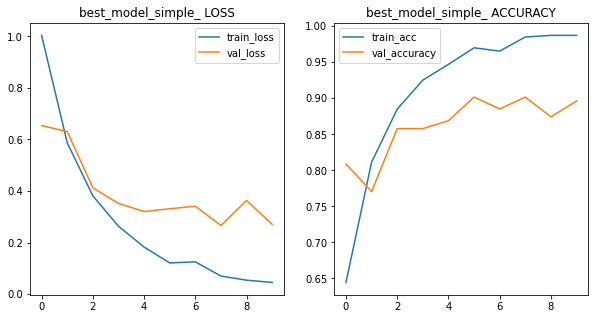

In [39]:
history_plot_from_loss_acc(history_model,'best_model_simple')

In [41]:
best_model = load_model('best_model_simple')
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 346112)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [42]:
best_model.evaluate(test_generator)

12/12 [==============================] - 1s 110ms/step - loss: 0.4766 - accuracy: 0.8361


[0.4765772223472595, 0.8360655903816223]

# VGG16 from Keras, model_vgg16_c

Build a convolutional neural network based on the [VGG16](https://neurohive.io/en/popular-networks/vgg16/) architecture.

In [43]:
import tensorflow. keras as keras
vgg16_model = keras.applications.VGG16()

553467904/553467096 [==============================] - 3s 0us/step


In [44]:
vgg16_model = keras.applications.vgg16.VGG16(
  weights='imagenet',
  include_top=False,
  input_shape=in_shape)

58892288/58889256 [==============================] - 1s 0us/step


In [45]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [46]:
vgg16_model.layers

In [ ]:
#vgg16_model.layers

In [47]:
model_vgg16_c = Sequential()
for layer in vgg16_model.layers:
  model_vgg16_c.add(layer)

In [ ]:
#model_2.layers

In [48]:
for layer in model_vgg16_c.layers:
  layer.trainable = False

In [49]:
model_vgg16_c.add(Flatten())
model_vgg16_c.add(Dense(256,activation='relu'))
model_vgg16_c.add(Dropout(0.5))
model_vgg16_c.add(Dense(5,activation='sigmoid'))
model_vgg16_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
#x = Flatten()(inputs)
#x = Dense(256)(x)
#x = Dropout(0.5)(x)

In [50]:
model_vgg16_c.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [51]:
mcp = ModelCheckpoint('keras_applications_VGG16', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [52]:
history_model_vgg16_c = model_vgg16_c.fit(train_generator,validation_data = valid_generator,epochs=15,callbacks=[mcp])    

Epoch 1/15
55/55 [==============================] - 16s 218ms/step - loss: 1.1447 - accuracy: 0.5995 - val_loss: 0.4592 - val_accuracy: 0.8579

Epoch 00001: val_accuracy improved from -inf to 0.85792, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 2/15
55/55 [==============================] - 9s 154ms/step - loss: 0.4448 - accuracy: 0.8260 - val_loss: 0.3585 - val_accuracy: 0.8798

Epoch 00002: val_accuracy improved from 0.85792 to 0.87978, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 3/15
55/55 [==============================] - 9s 159ms/step - loss: 0.2715 - accuracy: 0.9132 - val_loss: 0.3211 - val_accuracy: 0.8689

Epoch 00003: val_accuracy did not improve from 0.87978
Epoch 4/15
55/55 [==============================] - 9s 156ms/step - loss: 0.2119 - accuracy: 0.9319 - val_loss: 0.2818 - val_accuracy: 0.9126

Epoch 00004: val_accuracy improved from

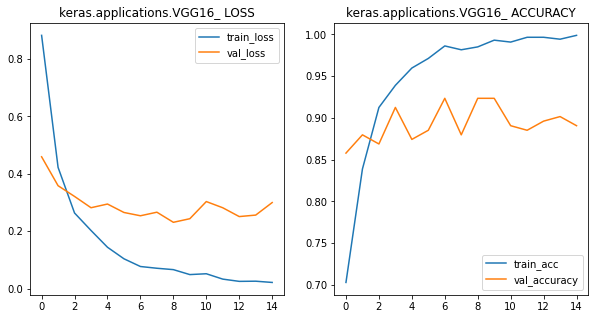

In [53]:
history_plot_from_loss_acc(history_model_vgg16_c,'keras.applications.VGG16')

In [54]:
best_keras_applications_VGG16_model = load_model('keras_applications_VGG16')

In [55]:
best_keras_applications_VGG16_model.evaluate(test_generator)

12/12 [==============================] - 2s 122ms/step - loss: 0.2565 - accuracy: 0.8852


[0.2565360367298126, 0.8852459192276001]

In [56]:
artist_dict = {1:'Caravaggio',2:'Giotto_di_Bondone',3:'Leonardo_da_Vinci',4:'Rembrandt',0:'Albrecht_Duerer'}

#### view result

In [ ]:
#main_target_path = '/content/local_data'
#all_subdir = 'data_set'
#train_subdir = 'train'
#val_subdir = 'valid'
#test_subdir = 'test'

In [57]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from numpy import array, matrix, multiply

In [ ]:
#test_generator.next()

/content/local_data/test/Caravaggio/Caravaggio_51.jpg
[[0.12415697 0.9935888  0.11766562 0.01759629 0.9533029 ]]
Caravaggio


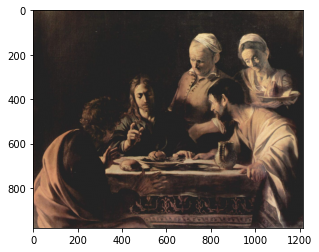

/content/local_data/test/Giotto_di_Bondone/Giotto_di_Bondone_91.jpg
[[0.15514112 0.36647967 0.99998164 0.0710507  0.397139  ]]
Giotto_di_Bondone


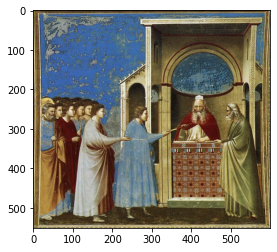

/content/local_data/test/Leonardo_da_Vinci/Leonardo_da_Vinci_62.jpg
[[0.8867478  0.00452193 0.25714695 0.9602838  0.26642853]]
Leonardo_da_Vinci


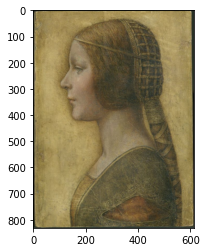

/content/local_data/test/Rembrandt/Rembrandt_78.jpg
[[0.25973603 0.06776221 0.0466756  0.20492299 0.9970497 ]]
Rembrandt


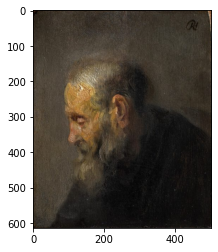

/content/local_data/test/Albrecht_Duerer/Albrecht_Duerer_y_286.jpg
[[0.99754435 0.01264196 0.17125185 0.65633714 0.05875369]]
Albrecht_Duerer


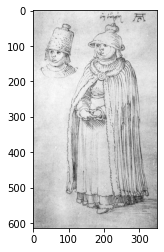

In [60]:
for art in artist_list:
  img_path = os.path.join(main_target_path,test_subdir,art)
  # Paths and Variables
  img_file_list=os.listdir(img_path)
  img_file=np.random.choice(img_file_list)
  
  img_rdn=cv2.imread(os.path.join(os.sep,img_path,img_file))
  img_rdn_cvt = cv2.cvtColor(img_rdn, cv2.COLOR_BGR2RGB)
  
  img_rdn_cvt = img_rdn_cvt/255
  img_rdn_rs = cv2.resize(img_rdn_cvt, (224, 224), interpolation = cv2.INTER_AREA)
  
  test_predict = model_vgg16_c.predict(np.expand_dims(img_rdn_rs, axis=0))
  max_predict = np.argmax(test_predict, axis=-1)

  print(os.path.join(os.sep,img_path,img_file))
  print(test_predict)
  print(artist_dict.get(max_predict[0]))

  plt.imshow(img_rdn_cvt)
  plt.show()


In [ ]:
#plt.imshow(cv2.cvtColor(img_rdn, cv2.COLOR_BGR2RGB))

In [160]:
#x_test_predict = model_vgg16_c.predict(test_generator)

In [ ]:
#x_test_predict

In [152]:
def plot_prediction(X_test,y_test,class_label,y_predict):
  plt.figure(figsize=(20,20))
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9)

  for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(X_test[i].reshape(28,28))
    plt.title("real "+class_label.get(y_test[i])+"\n predict "+class_label.get(y_test[i]))

  plt.show()

In [ ]:
in_shape

(224, 224, 3)

## resnet50

### top model

In [2]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Input, AveragePooling2D, Conv2D
from keras import initializers
from keras.callbacks import Callback


import tensorflow as tf

#from keras.backend.tensorflow_backend import set_session
#from keras.backend.tensorflow_backend import clear_session
#from keras.backend.tensorflow_backend import get_session

from keras.applications.resnet50 import ResNet50



In [61]:
resnet50 = ResNet50(include_top=False, input_shape=in_shape)
resnet50.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [65]:
dropout_rate = 0.3
num_classes = 5

# Top Model
a = Input(shape=(7,7,2048))
#x = AveragePooling2D(7,7)(name='avg_pool_1')(a)
x = AveragePooling2D(7,7)(a)
x = Flatten()(x)
x = Dropout(dropout_rate)(x)
x = Dense(2048, \
          kernel_initializer=initializers.he_normal(), \
          bias_initializer=initializers.ones(), \
          activation='relu')(x)
x = Dense(num_classes, kernel_initializer=initializers.he_normal(), \
          bias_initializer=initializers.ones(), activation='softmax')(x)
top_model = Model(inputs=a, outputs=x)

top_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 4,206,597
Trainable params: 4,206,597
Non-trainable params: 0
___________________________________________________

In [68]:
inp = Input(shape=in_shape)
y = resnet50(inp)
y = top_model(y)
final_model = Model(inp,y)

final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
model (Functional)           (None, 5)                 4206597   
Total params: 27,794,309
Trainable params: 27,741,189
Non-trainable params: 53,120
_________________________________________________________________


In [69]:
final_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [70]:
mcp = ModelCheckpoint('final_model', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [75]:
history_model_final_model = final_model.fit(train_generator,validation_data = valid_generator,epochs=15,callbacks=[mcp])    

Epoch 1/15
55/55 [==============================] - 12s 211ms/step - loss: 0.0219 - accuracy: 0.9908 - val_loss: 2.3655 - val_accuracy: 0.7432

Epoch 00001: val_accuracy did not improve from 0.74317
Epoch 2/15
55/55 [==============================] - 12s 209ms/step - loss: 0.0159 - accuracy: 0.9965 - val_loss: 1.0609 - val_accuracy: 0.8415

Epoch 00002: val_accuracy improved from 0.74317 to 0.84153, saving model to final_model
INFO:tensorflow:Assets written to: final_model/assets
Epoch 3/15
55/55 [==============================] - 12s 212ms/step - loss: 0.0182 - accuracy: 0.9965 - val_loss: 1.0091 - val_accuracy: 0.9016

Epoch 00003: val_accuracy improved from 0.84153 to 0.90164, saving model to final_model
INFO:tensorflow:Assets written to: final_model/assets
Epoch 4/15
55/55 [==============================] - 12s 209ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7762 - val_accuracy: 0.9071

Epoch 00004: val_accuracy improved from 0.90164 to 0.90710, saving model to final_mod

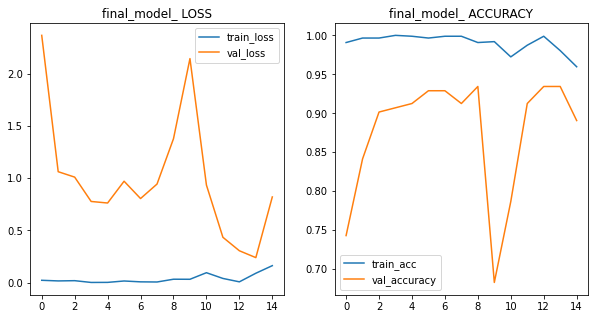

In [76]:
history_plot_from_loss_acc(history_model_final_model,'final_model')

In [77]:
best_final_model = load_model('final_model')

In [78]:
best_final_model.evaluate(test_generator)

12/12 [==============================] - 2s 122ms/step - loss: 0.7659 - accuracy: 0.9180


[0.7658597826957703, 0.9180327653884888]

/content/local_data/test/Caravaggio/Caravaggio_8.jpg
[[1.6871249e-08 9.9803036e-01 2.2501812e-08 9.7188647e-05 1.8723950e-03]]
Caravaggio


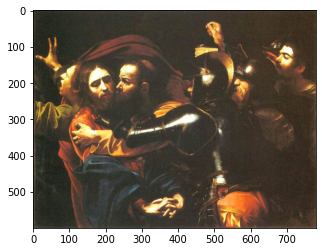

/content/local_data/test/Giotto_di_Bondone/Giotto_di_Bondone_67.jpg
[[3.7364084e-06 3.2397418e-07 9.9999547e-01 1.7644039e-08 4.5438139e-07]]
Giotto_di_Bondone


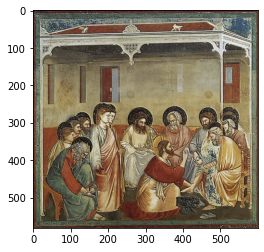

/content/local_data/test/Leonardo_da_Vinci/Leonardo_da_Vinci_62.jpg
[[7.2400081e-01 1.8574754e-03 3.4851770e-04 1.7620119e-01 9.7591989e-02]]
Albrecht_Duerer


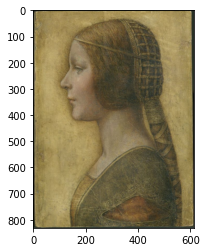

/content/local_data/test/Rembrandt/Rembrandt_234.jpg
[[3.0088464e-07 6.4668041e-07 3.8818535e-09 4.6951944e-05 9.9995208e-01]]
Rembrandt


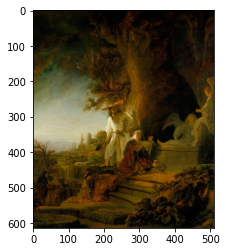

/content/local_data/test/Albrecht_Duerer/Albrecht_Duerer_x_249.jpg
[[1. 0. 0. 0. 0.]]
Albrecht_Duerer


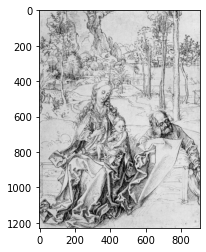

In [79]:
for art in artist_list:
  img_path = os.path.join(main_target_path,test_subdir,art)
  # Paths and Variables
  img_file_list=os.listdir(img_path)
  img_file=np.random.choice(img_file_list)
  
  img_rdn=cv2.imread(os.path.join(os.sep,img_path,img_file))
  img_rdn_cvt = cv2.cvtColor(img_rdn, cv2.COLOR_BGR2RGB)
  
  img_rdn_cvt = img_rdn_cvt/255
  img_rdn_rs = cv2.resize(img_rdn_cvt, (224, 224), interpolation = cv2.INTER_AREA)
  
  test_predict = best_final_model.predict(np.expand_dims(img_rdn_rs, axis=0))
  max_predict = np.argmax(test_predict, axis=-1)

  print(os.path.join(os.sep,img_path,img_file))
  print(test_predict)
  print(artist_dict.get(max_predict[0]))

  plt.imshow(img_rdn_cvt)
  plt.show()

# version B VGG16

In [ ]:
import tensorflow. keras as keras
vgg16_model = keras.applications.VGG16()
vgg16_model.summary()

In [ ]:
model_vgg16 = Sequential()
for layer in vgg16_model.layers:
  model_vgg16.add(layer)

In [ ]:
for layer in model_vgg16.layers:
  layer.trainable = False

In [ ]:
#model_vgg16.add(BatchNormalization())
model_vgg16.add(Dense(5,activation='softmax'))

In [ ]:
from keras.optimizers import Adam

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint('best_model_vgg16', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [ ]:
model_vgg16.compile(optimizer=Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_model_vgg16 = model_vgg16.fit(train_generator,validation_data = valid_generator,epochs=10,callbacks=[mcp])    

Epoch 1/10
55/55 [==============================] - 9s 156ms/step - loss: 1.5987 - accuracy: 0.5300 - val_loss: 1.5954 - val_accuracy: 0.5355

Epoch 00001: val_accuracy improved from -inf to 0.53552, saving model to best_model_vgg16
INFO:tensorflow:Assets written to: best_model_vgg16/assets
Epoch 2/10
55/55 [==============================] - 10s 174ms/step - loss: 1.5922 - accuracy: 0.5300 - val_loss: 1.5888 - val_accuracy: 0.5355

Epoch 00002: val_accuracy did not improve from 0.53552
Epoch 3/10
55/55 [==============================] - 9s 170ms/step - loss: 1.5857 - accuracy: 0.5300 - val_loss: 1.5821 - val_accuracy: 0.5355

Epoch 00003: val_accuracy did not improve from 0.53552
Epoch 4/10
55/55 [==============================] - 9s 170ms/step - loss: 1.5793 - accuracy: 0.5300 - val_loss: 1.5759 - val_accuracy: 0.5355

Epoch 00004: val_accuracy did not improve from 0.53552
Epoch 5/10
55/55 [==============================] - 9s 170ms/step - loss: 1.5731 - accuracy: 0.5300 - val_loss: 1

In [ ]:
history_plot_from_loss_acc(history_model_vgg16,'model_vgg16')

In [ ]:
model_vgg16.evaluate(test_generator)

In [ ]:
model_vgg

# Compare both models

Compare both models - which has more parameters?

Compile both models, train both models and evaluate both models on the test set.

Now try to tune the hyperparameters, including

*   Optimizer
*   Data Augmentation (look at what keras has under the hood)



Have you checked how "good" or "bad" the model performs for different painters? 

Just implement a function that gives you the accuracy and/or other metric for each class. 

Plot the class size vs. the accuracy (and or other metrics)

Are you happy with that result?

If not (and even if you are quite content), try to think how you could improve the project accuracy. Note that I have not written model accuracy!!!

Really do think about it - and then go on to the next quest!



# The End